# Homework 7 Solution

## FINM 36700 - 2024

### Group C 44
* Andy Andikko: andyandikko@uchicago.edu
* Harrison Zhang: harrisonzhang@uchicago.edu
* Matheus Raka Pradnyatama matheusraka@uchicago.edu

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import jinja2

from scipy.stats import norm
from functools import partial
from typing import Union, List
from sklearn.linear_model import LinearRegression

pd.options.display.float_format = "{:,.4f}".format
 
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
def summary_statistics_annualized(returns, annual_factor = 12): #returns index is date
    """This functions returns the summary statistics for the input total/excess returns passed
    into the function"""
    summary_statistics = pd.DataFrame(index=returns.columns)
    summary_statistics['Mean'] = returns.mean() * annual_factor
    summary_statistics['Volatility'] = returns.std() * np.sqrt(annual_factor)
    summary_statistics['Sharpe Ratio'] = (returns.mean() / returns.std()) * np.sqrt(annual_factor)
    summary_statistics['Min'] = returns.min()
    summary_statistics['Max'] = returns.max()
    summary_statistics['Skewness'] = returns.skew()
    summary_statistics['Excess Kurtosis'] = returns.kurtosis()
    summary_statistics['VaR (0.05)'] = returns.quantile(.05, axis = 0)
    summary_statistics['CVaR (0.05)'] = returns[returns <= returns.quantile(.05, axis = 0)].mean()
    return summary_statistics

In [4]:
def time_series_regression(portfolio, factors, multiple_factors = False, resid = False):
    
    ff_report = pd.DataFrame(index=portfolio.columns)
    bm_residuals = pd.DataFrame(columns=portfolio.columns)

    rhs = sm.add_constant(factors)

    for portf in portfolio.columns:
        lhs = portfolio[portf]
        res = sm.OLS(lhs, rhs, missing='drop').fit()
        ff_report.loc[portf, 'alpha_hat'] = res.params['const'] * 12
        if multiple_factors:
            ff_report.loc[portf, factors.columns[0] + ' beta'] = res.params[1]
            ff_report.loc[portf, factors.columns[1]+ ' beta'] = res.params[2] 
            ff_report.loc[portf, factors.columns[2]+ ' beta'] = res.params[3]
        else:
            ff_report.loc[portf, factors.name + ' beta'] = res.params[1]

            
        ff_report.loc[portf, 'info_ratio'] = np.sqrt(12) * res.params['const'] / res.resid.std()
        ff_report.loc[portf, 'treynor_ratio'] = 12 * portfolio[portf].mean() / res.params[1]
        ff_report.loc[portf, 'R-squared'] = res.rsquared
        ff_report.loc[portf, 'Tracking Error'] = (res.resid.std()*np.sqrt(12))

        if resid:
            bm_residuals[portf] = res.resid
            
            
        
    if resid:
        return bm_residuals
        
    return ff_report

In [5]:
def calc_return_metrics(data, as_df=False, adj=12):
    """
    Calculate return metrics for a DataFrame of assets.

    Args:
        data (pd.DataFrame): DataFrame of asset returns.
        as_df (bool, optional): Return a DF or a dict. Defaults to False (return a dict).
        adj (int, optional): Annualization. Defaults to 12.

    Returns:
        Union[dict, DataFrame]: Dict or DataFrame of return metrics.
    """
    summary = dict()
    summary["Annualized Return"] = data.mean() * adj
    summary["Annualized Volatility"] = data.std() * np.sqrt(adj)
    summary["Annualized Sharpe Ratio"] = (
        summary["Annualized Return"] / summary["Annualized Volatility"]
    )
    summary["Annualized Sortino Ratio"] = summary["Annualized Return"] / (
        data[data < 0].std() * np.sqrt(adj)
    )
    return pd.DataFrame(summary, index=data.columns) if as_df else summary


def calc_risk_metrics(data, as_df=False, var=0.05):
    """
    Calculate risk metrics for a DataFrame of assets.

    Args:
        data (pd.DataFrame): DataFrame of asset returns.
        as_df (bool, optional): Return a DF or a dict. Defaults to False.
        adj (int, optional): Annualizatin. Defaults to 12.
        var (float, optional): VaR level. Defaults to 0.05.

    Returns:
        Union[dict, DataFrame]: Dict or DataFrame of risk metrics.
    """
    summary = dict()
    summary["Skewness"] = data.skew()
    summary["Excess Kurtosis"] = data.kurtosis()
    summary[f"VaR ({var})"] = data.quantile(var, axis=0)
    summary[f"CVaR ({var})"] = data[data <= data.quantile(var, axis=0)].mean()
    summary["Min"] = data.min()
    summary["Max"] = data.max()

    wealth_index = 1000 * (1 + data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks) / previous_peaks

    summary["Max Drawdown"] = drawdowns.min()

    summary["Bottom"] = drawdowns.idxmin()
    summary["Peak"] = previous_peaks.idxmax()

    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][: drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin() :]]).T
        recovery_date.append(
            recovery_wealth[recovery_wealth[col] >= prev_max].index.min()
        )
    summary["Recovery"] = ["-" if pd.isnull(i) else i for i in recovery_date]

    summary["Duration (days)"] = [
        (i - j).days if i != "-" else "-"
        for i, j in zip(summary["Recovery"], summary["Bottom"])
    ]

    return pd.DataFrame(summary, index=data.columns) if as_df else summary


def calc_performance_metrics(data, adj=12, var=0.05):
    """
    Aggregating function for calculating performance metrics. Returns both
    risk and performance metrics.

    Args:
        data (pd.DataFrame): DataFrame of asset returns.
        adj (int, optional): Annualization. Defaults to 12.
        var (float, optional): VaR level. Defaults to 0.05.

    Returns:
        DataFrame: DataFrame of performance metrics.
    """
    summary = {
        **calc_return_metrics(data=data, adj=adj),
        **calc_risk_metrics(data=data, var=var),
    }
    summary["Calmar Ratio"] = summary["Annualized Return"] / abs(
        summary["Max Drawdown"]
    )
    return pd.DataFrame(summary, index=data.columns)

In [6]:
def calc_multivariate_regression(y, X, intercept=True, adj=12):
    """
    Calculate a multivariate regression of y on X. Adds useful metrics such
    as the Information Ratio and Tracking Error. Note that we can't calculate
    Treynor Ratio or Downside Beta here.

    Args:
        y : target variable
        X : independent variables
        intercept (bool, optional): Defaults to True.
        adj (int, optional): Annualization factor. Defaults to 12.

    Returns:
        DataFrame: Summary of regression results
    """
    if intercept:
        X = sm.add_constant(X)

    model = sm.OLS(y, X, missing="drop")
    results = model.fit()
    summary = dict()

    inter = results.params.iloc[0] if intercept else 0
    betas = results.params.iloc[1:] if intercept else results.params

    summary["Alpha"] = inter * adj
    summary["R-Squared"] = results.rsquared

    X_cols = X.columns[1:] if intercept else X.columns

    for i, col in enumerate(X_cols):
        summary[f"{col} Beta"] = betas[i]
    
    #summary['Sortino Ratio'] = y.mean() / y[y< 0].std() * np.sqrt(adj)
    summary["Information Ratio"] = (inter / results.resid.std()) * np.sqrt(adj)
    summary["Tracking Error"] = results.resid.std() * np.sqrt(adj)
   
    if isinstance(y, pd.Series):
        return pd.DataFrame(summary, index=[y.name])
    else:
        return pd.DataFrame(summary, index=y.columns)

## Reading the Data

In [7]:
path1 = '/Users/matheus/Desktop/finm-portfolio-2024/data/gmo_data.xlsx'
signals = pd.read_excel(path1, sheet_name = 'signals').set_index('date')
total_ret = pd.read_excel(path1, sheet_name = 'total returns').set_index('date')
# We need to convert the T-Bill 3M rate from annual numbers to monthly numbers 
# T-Bill 3M rates are usually presented as annual numbers 
rf = pd.read_excel(path1, sheet_name = 'risk-free rate').set_index('date') / 12
total_ret.head(2)

,SPY,GMWAX,GMGEX
date,,,
1996-12-31,-0.0233,-0.0221,-0.0130
1997-01-31,0.0618,0.0147,0.0344


## 2) Analyzing GMO

#### This section utilizes data in the file,`gmo_data.xlsx`.
#### Examine GMO's performance. Use the risk-free rate to convert the total returns to excess returns

### Converting total returns to excess returns in the portfolio

In [8]:
excess_ret = total_ret.sub(rf.values) # total return - risk free rate (substracting the RF)
excess_ret.head()

,SPY,GMWAX,GMGEX
date,,,
1996-12-31,-0.0276,-0.0264,-0.0173
1997-01-31,0.0575,0.0104,0.0302
1997-02-28,0.0052,0.0179,0.0084
1997-03-31,-0.0502,-0.0196,-0.0209
1997-04-30,0.0600,-0.0111,-0.0044


### 2.1) Calculate the mean, volatility, and Sharpe ratio for GMWAX. Do this for three samples:

### • from inception through 2011
### • 2012-present
### • inception - present

In [9]:
GMWAX = excess_ret[['GMWAX']]
SPY = excess_ret[['SPY']]
GMGEX = excess_ret[['GMGEX']]
GMWAX.head(2)

,GMWAX
date,
1996-12-31,-0.0264
1997-01-31,0.0104


In [10]:
pre2012_GMWAX = GMWAX.loc[:'2011']
post2012_GMWAX = GMWAX.loc['2012':]
alltime_GMWAX = GMWAX.copy()

df_dict={'Inception through 2011' : pre2012_GMWAX,
         '2012 - Present' : post2012_GMWAX,
         'Inception - Present' : alltime_GMWAX}

summary_lst = []
for key in df_dict.keys():
    # use appropriate function
    summary_stats = calc_performance_metrics(df_dict[key]).loc[:,['Annualized Return','Annualized Volatility','Annualized Sharpe Ratio']] 
    summary_stats['Period'] = key
    summary_stats= summary_stats.reset_index().rename(columns = {'index':'Variable'}).set_index(['Period','Variable'])
    summary_lst.append(summary_stats)

factor_summary = pd.concat(summary_lst)
factor_summary

,,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio
Period,Variable,,,
Inception through 2011,GMWAX,0.0464,0.1105,0.4201
2012 - Present,GMWAX,0.0434,0.0949,0.4573
Inception - Present,GMWAX,0.0450,0.1035,0.4352


## Has the mean, vol, and Sharpe changed much since the case?

Return has slightly decreased since the case. Volatility has dropped quite significantly, before and after the case. Consequently, Sharpe Ratio has increased since the case.

This shows that GMO's forecasts and subsequently, their asset allocation fund for GMWAX worked during this period of turmoil as compared to the previous sub-period of inception until 2011.

### 2.2 GMO believes a risk premium is compensation for a security's tendency to lose money at "bad times". For all three samples, analyze extreme scenarios by looking at 
### • Min return
### • 5th percentile (VaR-5th)
### • Maximum  Drawdown

In [11]:
pre2012_GMWAX = GMWAX.loc[:'2011']
post2012_GMWAX = GMWAX.loc['2012':]
alltime_GMWAX = GMWAX.copy()

df_dict={'Inception through 2011' : pre2012_GMWAX,
         '2012 - Present' : post2012_GMWAX,
         'Inception - Present' : alltime_GMWAX}

summary_lst = []
for key in df_dict.keys():
    # use appropriate function
    summary_stats = calc_performance_metrics(df_dict[key]).loc[:,['Min','VaR (0.05)','Max Drawdown']] 
    summary_stats['Period'] = key
    summary_stats= summary_stats.reset_index().rename(columns = {'index':'Variable'}).set_index(['Period','Variable'])
    summary_lst.append(summary_stats)

factor_summary = pd.concat(summary_lst)
factor_summary

,,Min,VaR (0.05),Max Drawdown
Period,Variable,,,
Inception through 2011,GMWAX,-0.1492,-0.0440,-0.3065
2012 - Present,GMWAX,-0.1150,-0.0409,-0.2256
Inception - Present,GMWAX,-0.1492,-0.0414,-0.3065


### 2.2.a) Does GMWAX have high or low tail-risk as seen by these stats

GMWAX seems to have low tail-risk as depicted by the tail risk statistics above. <br>
The 5% VaR is only around -7% to -8%. The lowest return of GMWAX is only -19%. 

### 2.2.b) Does that vary much across the two subsamples?

The tail risk is especially low in the latter sub-period of 2012-Present. 5% Var is smaller in magnitude and the minimum return is higher in the latter sub-period.
This could be a factor of two aspects, better forecasting by GMO or reduced sub-sample length leading to less market downturns.

### 2.3) For all three samples, regress excess returns of GMWAX on excess returns of SPY.
### 2.3.a) Report the estimated alpha, beta, and r-squared.

In [12]:
pre2012_SPY = SPY.loc[:'2011']
post2012_SPY = SPY.loc['2012':]
alltime_SPY = SPY.copy()

pre2012_reg = calc_multivariate_regression(y=pre2012_GMWAX, X=pre2012_SPY, intercept=True, adj=12).loc[:,['Alpha','SPY Beta', 'R-Squared']]
post2012_reg = calc_multivariate_regression(y=post2012_GMWAX, X=post2012_SPY, intercept=True, adj=12).loc[:,['Alpha','SPY Beta', 'R-Squared']] 
alltime_reg = calc_multivariate_regression(y=alltime_GMWAX, X=alltime_SPY, intercept=True, adj=12).loc[:,['Alpha','SPY Beta', 'R-Squared']] 

# Make a new data frame to compare the different regressions
reg1 = pd.DataFrame(columns = ['Alpha','SPY Beta', 'R-Squared'])
reg1.loc['Inception through 2011',:] = pre2012_reg.values
reg1.loc['2012 - Present',:] = post2012_reg.values
reg1.loc['Inception - Present',:] = alltime_reg.values
reg1

,Alpha,SPY Beta,R-Squared
Inception through 2011,0.0270,0.5421,0.6487
2012 - Present,-0.0340,0.5818,0.7487
Inception - Present,0.0006,0.5526,0.6802


### 2.3.b) Is GMWAX a low-beta strategy? Has that changed since the case?

GMWAX seems to have a moderately low beta with the market: ~0.6. Since the beta is less than 1, we can consider it a low-beta strategy. The beta remains quite stable across both sub-samples.

### 2.3.c) Does GMWAX provide alpha? Has that changed across the subsamples?
In the first subsample, yes, but we can see that it has a negative alpha since the case (shown by the second subsample). 

All in all, we find that GMWAX has had mediocre relative performance, particularly since 2012. With a beta close to 0.5 with SPY but a lower Sharpe and a negative skew, it seems that GMWAX is not quite attractive. This is demonstrated further by the negative alpha since 2012. It is important to note that this does not solidify the case against GMWAX. For one, it could be capturing a different risk measure, or have exposure to a different risk measure than market risk. If the premium of such a measure turned negative since 2012, one may actually find GMWAX's alpha to be positive.

Lastly, and reflective of GMO's strategy, GMWAX tends to have its returns come from a few large return months (positve, or negative), which is consistent with the large excess kurtosis statistic found before. This is also consistent with the beliefs behind GMO's strategy, which often leads to "contrarian" positions aimed at price bubbles that can move precipitously.

### 2.4) Above, we’ve evaluated GMO’s macro fund, ”GMWAX”, as studied in the case. Now, consider GMO’s equity fund, ”GMGEX”.
Compute the performance stats of 3.1-3.3 for GMGEX. What are some of the major differences between these two strategies?

In [13]:
pre2012_GMGEX = GMGEX.loc[:'2011']
post2012_GMGEX = GMGEX.loc['2012':]
alltime_GMGEX= GMGEX.copy()

df_dict={'Inception through 2011' : pre2012_GMGEX,
         '2012 - Present' : post2012_GMGEX,
         'Inception - Present' : alltime_GMGEX}

summary_lst = []
for key in df_dict.keys():
    # use appropriate function
    summary_stats = calc_performance_metrics(df_dict[key]).loc[:,['Annualized Return','Annualized Volatility','Annualized Sharpe Ratio', 'Min','VaR (0.05)','Max Drawdown']] 
    summary_stats['Period'] = key
    summary_stats= summary_stats.reset_index().rename(columns = {'index':'Variable'}).set_index(['Period','Variable'])
    summary_lst.append(summary_stats)

factor_summary = pd.concat(summary_lst)
factor_summary

,,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio,Min,VaR (0.05),Max Drawdown
Period,Variable,,,,,,
Inception through 2011,GMGEX,-0.0038,0.1473,-0.0260,-0.1516,-0.0823,-0.5640
2012 - Present,GMGEX,0.0013,0.2356,0.0056,-0.6589,-0.0680,-0.7383
Inception - Present,GMGEX,-0.0015,0.1926,-0.0076,-0.6589,-0.0762,-0.7681


In [14]:
pre2012_SPY = SPY.loc[:'2011']
post2012_SPY = SPY.loc['2012':]
alltime_SPY = SPY.copy()

pre2012_reg2 = calc_multivariate_regression(y=pre2012_GMGEX, X=pre2012_SPY, intercept=True, adj=12).loc[:,['Alpha','SPY Beta', 'R-Squared']]
post2012_reg2 = calc_multivariate_regression(y=post2012_GMGEX, X=post2012_SPY, intercept=True, adj=12).loc[:,['Alpha','SPY Beta', 'R-Squared']] 
alltime_reg2 = calc_multivariate_regression(y=alltime_GMGEX, X=alltime_SPY, intercept=True, adj=12).loc[:,['Alpha','SPY Beta', 'R-Squared']] 

# Make a new data frame to compare the different regressions
reg2 = pd.DataFrame(columns = ['Alpha','SPY Beta', 'R-Squared'])
reg2.loc['Inception through 2011',:] = pre2012_reg2.values
reg2.loc['2012 - Present',:] = post2012_reg2.values
reg2.loc['Inception - Present',:] = alltime_reg2.values
reg2

,Alpha,SPY Beta,R-Squared
Inception through 2011,-0.0312,0.7642,0.7259
2012 - Present,-0.1102,0.8381,0.2525
Inception - Present,-0.0648,0.7867,0.3979


All in all, we find that GMWAX has had mediocre relative performance, particularly since 2012. With a beta close to 0.5 with SPY but a lower Sharpe and a negative skew, it seems that GMWAX is not quite attractive. This is demonstrated further by the negative alpha since 2012. It is important to note that this does not solidify the case against GMWAX. For one, it could be capturing a different risk measure, or have exposure to a different risk measure than market risk. If the premium of such a measure turned negative since 2012, one may actually find GMWAX's alpha to be positive.

Lastly, and reflective of GMO's strategy, GMWAX tends to have its returns come from a few large return months (positve, or negative), which is consistent with the large excess kurtosis statistic found before. This is also consistent with the beliefs behind GMO's strategy, which often leads to "contrarian" positions aimed at price bubbles that can move precipitously.

## 3 Forecast Regressions

#### This section utilizes data in the file,`gmo_data.xlsx`.

### 3.1) Consider the lagged regression, where the regressor, ($X$), is a period behind the target, ($r^{SPY}$).

### Estimate (1) and report the $R^2$, as well as the OLS estimates for $\alpha$ and $\beta$. Do this for...
- $X$ as a single regressor, the dividend-price ratio.
- $X$ as a single regressor, the earnings-price ratio.
- $X$ as three regressors, the dividend-price ratio, the earnings-price ratio, and the 10-year yield.

### For each, report the r-squared.

In [15]:
path1 = '/Users/matheus/Desktop/finm-portfolio-2024/data/gmo_data.xlsx'
signals = pd.read_excel(path1, sheet_name = 'signals').set_index('date')
total_ret = pd.read_excel(path1, sheet_name = 'total returns').set_index('date')
# We need to convert the T-Bill 3M rate from annual numbers to monthly numbers 
# T-Bill 3M rates are usually presented as annual numbers 
rf = pd.read_excel(path1, sheet_name = 'risk-free rate').set_index('date') / 12
total_ret.head(2)

,SPY,GMWAX,GMGEX
date,,,
1996-12-31,-0.0233,-0.0221,-0.0130
1997-01-31,0.0618,0.0147,0.0344


In [16]:
# Use SPY Excess return

# SPY Total Return
rets = total_ret[['SPY']]
retsx = rets.subtract(rf['TBill 3M'],axis=0)
retsx.head(3)

,SPY
date,
1996-12-31,-0.0276
1997-01-31,0.0575
1997-02-28,0.0052


In [17]:
DP = signals[['SPX DVD YLD']]
PE = signals[['SPX P/E']] # Price-Earnings Ratio
EP = 1/signals[['SPX P/E']] # reciprocical of P/E
US10Y = signals[['TNote 10YR']]

DP.head(2)

,SPX DVD YLD
date,
1996-12-31,1.9651
1997-01-31,1.8455


In [18]:
# Shift all the data in Signals
signals_lag = signals.shift(1).squeeze() 
signals_lag.head(3)

,SPX DVD YLD,SPX P/E,TNote 10YR
date,,,
1996-12-31,NaN,NaN,NaN
1997-01-31,1.9651,19.6873,6.4180
1997-02-28,1.8455,20.8856,6.4940


In [19]:
# For t-1, shift by (1)
# For t+1, shift by (-1)

DP_lag = DP.shift(1).squeeze() # lagged by 1
PE_lag = PE.shift(1).squeeze() # lagged by 1

signal_reg_1 = time_series_regression(retsx, DP_lag, multiple_factors = False, resid = False)
signal_reg_1.index = ['DP'] # renaming row

signal_reg_2 = time_series_regression(retsx, PE_lag, multiple_factors = False, resid = False)
signal_reg_2.index = ['PE']

# multiple factors = True
signal_reg_3 = time_series_regression(retsx, signals_lag, multiple_factors = True, resid = False)
signal_reg_3.index = ['DP, PE, US10Y']

# display all regressions
display(signal_reg_1,signal_reg_2,signal_reg_3)

,alpha_hat,SPX DVD YLD beta,info_ratio,treynor_ratio,R-squared,Tracking Error
DP,-0.2055,0.0132,-1.3394,6.1046,0.0140,0.1535


,alpha_hat,SPX P/E beta,info_ratio,treynor_ratio,R-squared,Tracking Error
PE,0.2721,-0.0008,1.7662,-100.2990,0.0060,0.1541


,alpha_hat,SPX DVD YLD beta,SPX P/E beta,TNote 10YR beta,info_ratio,treynor_ratio,R-squared,Tracking Error
"DP, PE, US10Y",-0.1865,0.0126,0.0002,-0.0015,-1.2170,6.3650,0.0165,0.1533


As stated in class, R-Squared should be low. There should be other factors that can explain the return on SPY apart from these ratios and USG10YR. 

### 3.2) For each of the three regressions, let’s try to utilize the resulting forecast in a trading strategy.
- Build the forecasted SPY returns: $\hat{r}^{SPY}_{t+1}$. Note that this denotes the forecast made using $X_t$ to forecast the $(t+1)$ return.
- Set the scale of the investment in SPY equal to 100 times the forecasted value:
$
w_t = 100 \hat{r}^{SPY}_{t+1}
$
- We are not taking this scaling too seriously. We just want the  strategy  to  go  bigger  inperiods where the forecast is high and to withdraw in periods where the forecast is low, or even negative.
- Calcualte the return on this strategy:
$
r^X_{t+1} = w_tr^{SPY}_{t+1}
$

#### You should now have the trading strategy returns, $r^x$ for each of the forecasts. For each strategy, estimate:
- mean, volatility, Sharpe,
- max-drawdown
- market alpha
- market beta
- market Information

## Strategy 1: dividend-price ratio

In [20]:
# Predicted Y = alpha/12 + estimated beta * x
alpha = signal_reg_1['alpha_hat'].values
beta = signal_reg_1['SPX DVD YLD beta'].values

DP_return = (DP_lag.to_frame() * beta) + alpha/12
DP_return.head(3)

,SPX DVD YLD
date,
1996-12-31,NaN
1997-01-31,0.0088
1997-02-28,0.0072


In [21]:
# Scaled Y = Predicted Y * 100
DP_return = DP_return * 100
DP_return.head(3)

,SPX DVD YLD
date,
1996-12-31,NaN
1997-01-31,0.8785
1997-02-28,0.7208


In [22]:
# Compute the strategy returns
DP_forecast_return = pd.DataFrame(DP_return * retsx.values, columns=DP_return.columns, index=DP_return.index)
DP_forecast_return = DP_forecast_return.dropna()
DP_forecast_return.head(3) # This is the strategy return

,SPX DVD YLD
date,
1997-01-31,0.0505
1997-02-28,0.0038
1997-03-31,-0.0365


In [23]:
performance_DP = calc_performance_metrics(DP_forecast_return)
performance_DP

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio,Annualized Sortino Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Min,Max,Max Drawdown,Bottom,Peak,Recovery,Duration (days),Calmar Ratio
SPX DVD YLD,0.0891,0.1654,0.5388,0.5653,-0.1031,15.8210,-0.0492,-0.1070,-0.2992,0.2997,-0.7244,2009-02-27,2024-10-31,2012-02-29,1097,0.1230


## Strategy 2: Earnings-price ratio

In [24]:
# Predicted Y = alpha/12 + estimated beta * x
alpha = signal_reg_2['alpha_hat'].values
beta = signal_reg_2['SPX P/E beta'].values

PE_return = (PE_lag.to_frame() * beta) + alpha/12
PE_return.head(3)

,SPX P/E
date,
1996-12-31,NaN
1997-01-31,0.0069
1997-02-28,0.0059


In [25]:
# Scaled Y = Predicted Y * 100
PE_return = PE_return * 100

# Compute the strategy returns
PE_forecast_return = pd.DataFrame(PE_return * retsx.values, columns=PE_return.columns, index=PE_return.index)
PE_forecast_return = PE_forecast_return.dropna()
PE_forecast_return.head(3) # This is the strategy return

,SPX P/E
date,
1997-01-31,0.0395
1997-02-28,0.0031
1997-03-31,-0.0292


In [26]:
# Performance measure
performance_PE = calc_performance_metrics(PE_forecast_return)
performance_PE

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio,Annualized Sortino Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Min,Max,Max Drawdown,Bottom,Peak,Recovery,Duration (days),Calmar Ratio
SPX P/E,0.0700,0.1233,0.5679,0.6896,-0.4497,4.2956,-0.0494,-0.0840,-0.1751,0.1368,-0.5590,2009-02-27,2024-09-30,2012-03-30,1127,0.1252


## Strategy 3: dividend-price ratio, the earnings-price ratio, and the 10-year yield

In [27]:
y = retsx['SPY']
x = sm.add_constant(signals).shift()

model_all = sm.OLS(y,x,missing='drop').fit()

print(model_all.summary())

                            OLS Regression Results                            
Dep. Variable:                    SPY   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.841
Date:                Mon, 09 Dec 2024   Prob (F-statistic):              0.140
Time:                        11:08:20   Log-Likelihood:                 567.99
No. Observations:                 334   AIC:                            -1128.
Df Residuals:                     330   BIC:                            -1113.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0155      0.036     -0.429      

In [28]:
# Build the return predictions, and align them with the right period
all_prediction = model_all.predict(sm.add_constant(signals)).shift()

# Build the strategy weighting in SPY
all_weight = 100 * all_prediction

# Compute the strategy returns
all_strat = all_weight * retsx['SPY']
all_strat = all_strat.dropna()
all_strat = all_strat.to_frame("3 Regressors")
all_strat.head(3)

,3 Regressors
date,
1997-01-31,0.0245
1997-02-28,0.0015
1997-03-31,-0.0147


In [29]:
# Performance measure
performance_all = calc_performance_metrics(all_strat)
performance_all

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio,Annualized Sortino Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Min,Max,Max Drawdown,Bottom,Peak,Recovery,Duration (days),Calmar Ratio
3 Regressors,0.0949,0.1653,0.5739,0.6336,0.1128,12.4856,-0.0475,-0.1063,-0.2775,0.2839,-0.6785,2009-02-27,2024-09-30,2011-01-31,703,0.1398


In [30]:
pd.concat([performance_DP,performance_PE,performance_all]).T

,SPX DVD YLD,SPX P/E,3 Regressors
Annualized Return,0.0891,0.0700,0.0949
Annualized Volatility,0.1654,0.1233,0.1653
Annualized Sharpe Ratio,0.5388,0.5679,0.5739
Annualized Sortino Ratio,0.5653,0.6896,0.6336
Skewness,-0.1031,-0.4497,0.1128
Excess Kurtosis,15.8210,4.2956,12.4856
VaR (0.05),-0.0492,-0.0494,-0.0475
CVaR (0.05),-0.1070,-0.0840,-0.1063
Min,-0.2992,-0.1751,-0.2775
Max,0.2997,0.1368,0.2839


In [31]:
strategy = {'DP': DP_forecast_return.dropna(),
          'EP': PE_forecast_return.dropna(),
          'DP-EP-US10Y': all_strat.dropna()
         }
# SPY Excess Return
excess_SPY = excess_ret[['SPY']]
factor = excess_SPY

total_strategy_summary = []

for key,value in strategy.items():
    strat = strategy[key]
    strat_summary = calc_performance_metrics(strat)
    strat_summary.index = [key]
    strat_summary['Negative Risk Premium Months'] = len(strat[strat - rf[['TBill 3M']] <0])
    strat_summary['Total Months'] = len(strat)

    # Time series, Y = Strategy Forecast Return, X = SPY Total Return
    ts = time_series_regression(strat, factor[strat.index[0]:].squeeze(), False)
    strat_summary['Market Beta'] = ts['SPY beta'].values
    strat_summary['Market Alpha'] = ts['alpha_hat'].values
    strat_summary['Market Information Ratio'] = ts['info_ratio'].values
    
    total_strategy_summary.append(strat_summary)
    
total_strategy_df = pd.concat(total_strategy_summary)
  
total_strategy_df.loc[:,['Annualized Return','Annualized Volatility','Annualized Sharpe Ratio','Max Drawdown','Market Beta','Market Alpha','Market Information Ratio']]


,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio,Max Drawdown,Market Beta,Market Alpha,Market Information Ratio
DP,0.0891,0.1654,0.5388,-0.7244,0.7876,0.0247,0.2208
EP,0.0700,0.1233,0.5679,-0.5590,0.7074,0.0122,0.2141
DP-EP-US10Y,0.0949,0.1653,0.5739,-0.6785,0.7746,0.0315,0.2768


### 3.3) GMO believes a risk premium is compensation for a security's tendency to lose money at "bad times". Let's consider risk characteristics.

### 3.3.a) For both strategies, the market, and GMO, calculate the monthly VaR for $\pi=.05$. Just use the quantile of the historic data for this VaR calculation.

In [32]:
market_summary = calc_performance_metrics(excess_SPY)
gmo_summary = calc_performance_metrics(excess_ret[['GMWAX']].dropna())
strat_var= pd.concat([total_strategy_df.loc[:,['VaR (0.05)']],
                      market_summary.loc[:,['VaR (0.05)']],
                      gmo_summary.loc[:,['VaR (0.05)']]])
strat_var

,VaR (0.05)
DP,-0.0492
EP,-0.0494
DP-EP-US10Y,-0.0475
SPY,-0.0797
GMWAX,-0.0414


### 3.3.b) The GMO case mentions that stocks under-performed short-term bonds from 2000-2011. Does the dynamic portfolio above under-perform the risk-free rate over this time?

All dynamic portfolios outperform the risk-free rate.

### 3.3.c) Based on the regression estimates, in how many periods do we estimate a negative risk premium?

In [34]:
neg_risk_premium = total_strategy_df.loc[:,['Negative Risk Premium Months','Total Months']]
neg_risk_premium['Negative Risk Premium Months (%)'] = neg_risk_premium['Negative Risk Premium Months'] *100/ neg_risk_premium['Total Months']
neg_risk_premium

,Negative Risk Premium Months,Total Months,Negative Risk Premium Months (%)
DP,334,334,100.0000
EP,334,334,100.0000
DP-EP-US10Y,334,334,100.0000


### 3.3.d) Do you believe the dynamic strategy takes on extra risk?

No, judging by the tail risk metrics and volatility of the dynamic strategies compared to SPY, it does not seem like these strategies take on extra risk on the whole.

However, we must keep in mind that the strategies are dependent on running regressions with very little prediction power. Poorly estimated parameters could lead to terrible performance. This is not evident in terms of very high volatility and tail risk in our backtesting period though.

In [ ]:
total_strategy_df.loc[:,['Annualized Return','Annualized Volatility','Annualized Sharpe Ratio','VaR (0.05)','Max Drawdown','Market Beta','Market Alpha','Market Information Ratio']]

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio,VaR (0.05),Max Drawdown,Market Beta,Market Alpha,Market Information Ratio
DP,0.0977,0.1654,0.5904,-0.0487,-0.7189,0.7896,0.0331,0.2967
EP,0.0820,0.1310,0.6261,-0.0460,-0.6035,0.7306,0.0223,0.3358
DP-EP-US10Y,0.1007,0.1653,0.6097,-0.0469,-0.6732,0.7762,0.0373,0.3282


In [ ]:
market_summary.loc[:,['Annualized Return','Annualized Volatility','Annualized Sharpe Ratio','VaR (0.05)','Max Drawdown']]

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio,VaR (0.05),Max Drawdown
SPY,0.0805,0.1545,0.5212,-0.0797,-0.5592


## 4. Out-of-Sample Forecasting

#### This section utilizes data in the file,`gmo_data.xlsx`.

Reconsider the problem above, of estimating (1) for $x$. The reported $R^2$ was the in-sample $R^2$ it examined how well the forecasts fit in the sample from which the parameters were estimated. <br><br>

**In particular, focus on the case of using both dividend-price and earnings-price as signals.**

Let's consider the out-of-sample r-squared. To do so, we need the following:
- Start at $t=60$.
- Estmiate (1) only using data through time $t$.
- Use the estimated parameters of (1), along with $x_{t+1}$ to calculate the out-of-sample forecast for the following period, $t+1$.
\begin{align}
\hat{r}^{SPY}_{t+1} = \hat{a}^{SPY,x}_t+(\beta^{SPY,x})'x_t 
\end{align}
- Calculate the $t+1$ forecast error,
\begin{align}
  e^x_{t+1} = r^{SPY}_{t+1} - \hat{r}^{SPY}_{t+1}
\end{align}
- Move to $t=61$, and loop through the rest of the sample.

You now have the time-series of out-of-sample prediction errors, $e^x$.

Calculate the time-series of out-of-sample prediction errors $e^0$, which are based on the null forecast:
\begin{align*}
\bar{r}^{SPY}_{t+1} &= \frac{1}{t}\sum^{t}_{i=1}r^{SPY}_i \\
e^0_{t+1} &= r^{SPY}_{t+1} - \bar{r}^{SPY}_{t+1}
\end{align*}


### 4.1) Report the out-of-sample $R^2$:

### note that unlike an in-sample r-squared, the out-of-sample r-squared can be anywhere between $(-\infty,1]$.
### Did this forecasting strategy produce a positive OOS r-squared?


In [36]:
def oos_forecast(signals, asset, t = 60, rolling = False, roll_exp = False, intercept = True):
    
    '''
    Computes an out-of-sample forecast based on expanding regression periods
    
    signals: DataFrame containing the signals (regressors) to be used in each regression
    asset: DataFrame containing the values (returns) of the asset being predicted
    t: The minimum number of periods
    rolling: False if expanding, else enter an integer window
    roll_exp: If using rolling, indicate whether to use expanding up to the minimum periods 
    intercept: Boolean indicating the inclusion of an intercept in the regressions
    '''
    
    n = len(signals)
    
    if intercept:
        signals = sm.add_constant(signals)
    
    if t > n:
        
        raise ValueError('Min. periods (t) greater than number of data points')
    
    output = pd.DataFrame(index = signals.index, columns = ['Actual','Predicted','Null'])
    
    # If expanding
    if not rolling:
        
        for i in range(t,n):

            y = asset.iloc[:i]
            x = signals.iloc[:i].shift()

            if intercept:
                null_pred = y.mean()

            else:
                null_pred = 0

            model = sm.OLS(y,x,missing='drop').fit()

            pred_x = signals.iloc[[i - 1]]
            pred = model.predict(pred_x)[0]

            output.iloc[i]['Actual'] = asset.iloc[i]
            output.iloc[i]['Predicted'] = pred
            output.iloc[i]['Null'] = null_pred
    
    # If rolling
    else:
        
        if rolling > n:
            
            raise ValueError('Rolling window greater than number of data points')
        
        y = asset
        x = signals.shift()
        
        if intercept:
            
            if roll_exp:
                null_pred = y.rolling(window = rolling, min_periods = 0).mean().shift()
            else:
                null_pred = y.rolling(window = rolling).mean().shift()

        else:
            null_pred = 0
        
        # When expanding == True, there is a minimum number of observations
        # Keep ^ in mind
        model = RollingOLS(y,x,window = rolling, expanding = roll_exp).fit()

        output['Actual'] = asset
        output['Predicted'] = (model.params * signals).dropna().sum(axis=1).shift()
        output['Null'] = null_pred
        
        
    return output


def oos_r_squared(data):
    
    '''
    Computes the out-of-sample r squared
    data: DataFrame containing actual, model-predicted, and null-predicted values
    '''
    
    model_error = data['Actual'] - data['Predicted']
    null_error = data['Actual'] - data['Null']
    
    r2_oos = 1 - (model_error ** 2).sum() / (null_error ** 2).sum()
    
    return r2_oos


# Create a trading returns func that takes in a trading implementation func

In [40]:
oos_ep_dp = oos_forecast(signals[['SPX DVD YLD', 'SPX P/E']], retsx['SPY'])
print(oos_r_squared(oos_ep_dp))

-0.0576915804028153


This forecasting strategy produces a negative OOS r-squared, which indicates our strategy fits the data worse than a horizontal line given by the expanding mean of the sample.

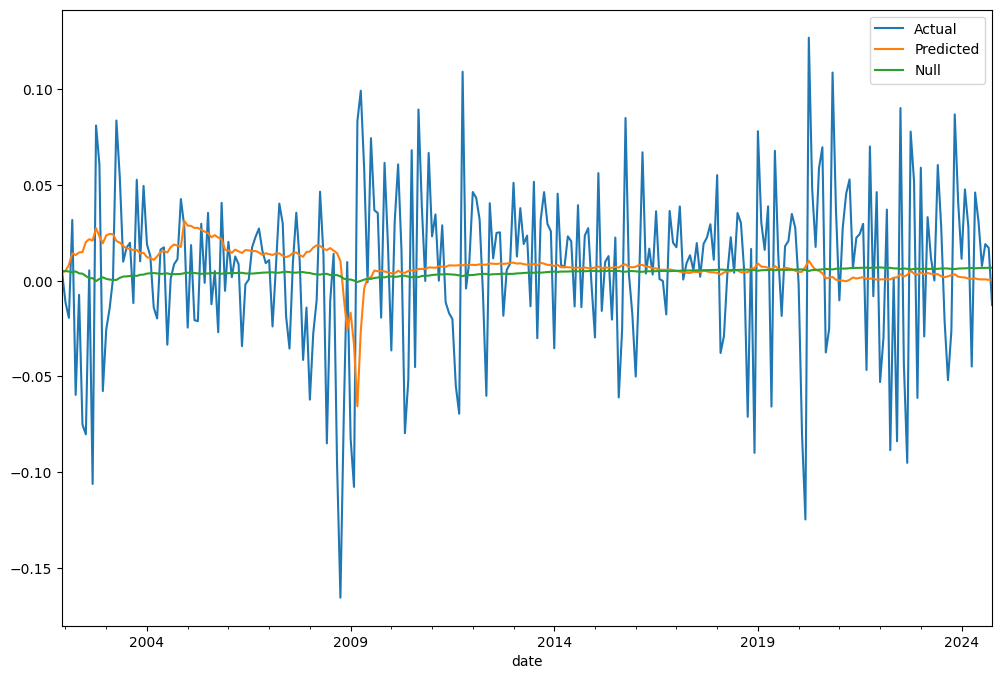

In [41]:
oos_ep_dp.dropna().plot(figsize=(12,8))
plt.show()

### 4.2) Re-do problem 3.2 using this OOS forecast. <br><br> How much better/worse is the OOS strategy compared to the in-sample version of 3.2?

The Out-of-Sample performs significantly worse than in-sample as expected. With lower mean, much higher volatility and tail risk measure, the OOS performance seems to be taking much higher risk with a large negative beta to the market returns.

In [49]:
# Weight = 100 * Predicted Value 
ep_dp_oos_weight = 100 * oos_ep_dp['Predicted']
# Strategy Return = Weight * Actual Return 
ep_dp_oos_strat = (ep_dp_oos_weight * oos_ep_dp['Actual']).astype(float)
OOS_strat_return = ep_dp_oos_strat.to_frame("OOS Strat Return").dropna()
OOS_strat_return.head(3)

,OOS Strat Return
date,
2001-12-31,0.0017
2002-01-31,-0.0057
2002-02-28,-0.0160


In [50]:
summary_statistics_annualized(OOS_strat_return, annual_factor = 12) #returns index is date

,Mean,Volatility,Sharpe Ratio,Min,Max,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05)
OOS Strat Return,0.0467,0.2147,0.2175,-0.5467,0.3588,-2.2561,28.1469,-0.0605,-0.1612


In [59]:
# Redefine the above function
def LFPM_TS(assets, factors, annualize = 12, name = 'asset', treynor = False, mkt_name = 'MKT'):
    '''Alpha, IR, Treynor are annualized (only the stats output)'''

    if isinstance(assets,pd.Series):
        assets = pd.DataFrame(assets)
        assets.columns = [name]
    
    if isinstance(factors,pd.Series):
        factors = pd.DataFrame(factors)
    
    model_output = pd.DataFrame()
    stats_output = pd.DataFrame()
    residuals_output = pd.DataFrame()
    
    x = sm.add_constant(factors)
    
    for asset in assets.columns:
        
        # Create the model
        y = assets[asset]
        model = sm.OLS(y,x,missing='drop').fit()
        
        # Create the parameters dataframe
        model_output[asset] = model.params
        
        # Create the statistics dataframe
        mu = y.mean() * annualize
        alpha = model.params[0] * annualize
        sig_ep = model.resid.std() * np.sqrt(annualize)
        IR = alpha / sig_ep
        r_squared = model.rsquared
        
        stats_output[asset] = pd.Series(data = [alpha,IR,r_squared],index = ['Alpha','IR','R^2'])
        
        if treynor:
            mkt = model.params[mkt_name]
            TR = mu / mkt
            
            stats_output.loc['Treynor',asset] = TR
        
        # Create the residuals dataframe
        residuals_output[asset] = model.resid
        
    return model_output, stats_output, residuals_output

In [60]:
LFPM_TS(ep_dp_oos_strat,retsx['SPY'])[1]

,asset
Alpha,0.0012
IR,0.0058
R^2,0.1396


### 4.3) Re-do problem 3.3 using this OOS forecast. <br><br> Is the point-in-time version of the strategy riskier?

Compared to the full sub-sample, the mean returns go down significantly during 2000-2011.The volatility slightly increasesthus the strategy experiences a lower Sharpe Ratio. Given the lower performance of the strategy and worse tail risk measures compared to SPY, the strategy does take on extra risk.

### 4.3.a) Monthly VaR 0.05

In [63]:
OOS_var = ep_dp_oos_strat.quantile(0.05)
print(OOS_var)

-0.06051014396734978


The 5% VaR of the strategy is notably worse than the in-sample version, but still more positive than that of SPY.

### 4.3b) Does the dynamic portfolio above under-perform the risk-free rate over this time?

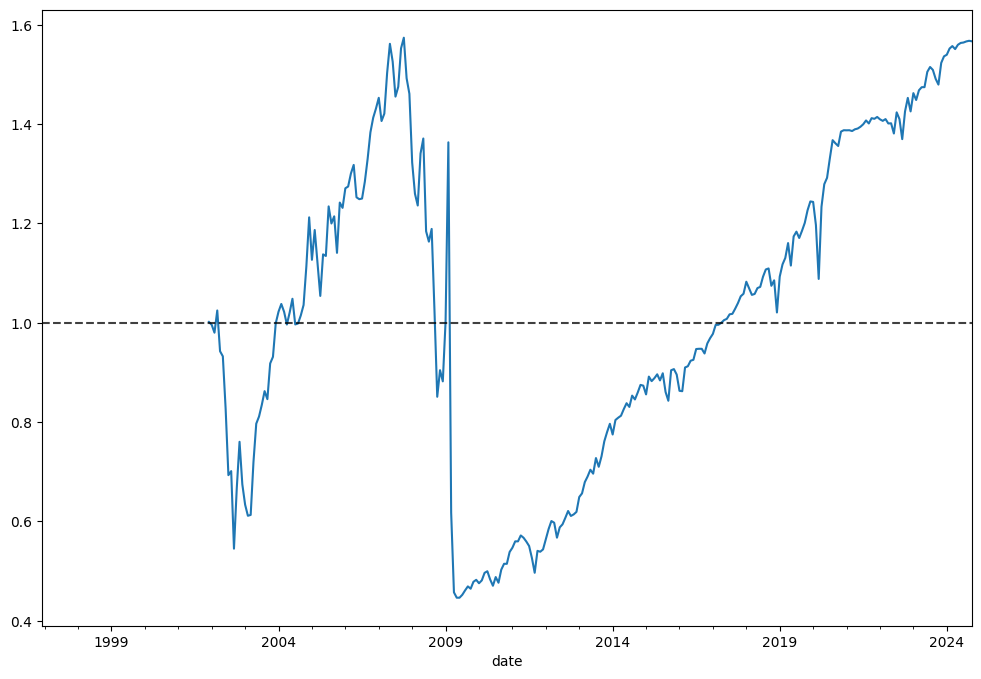

In [65]:
(1 + ep_dp_oos_strat).cumprod().plot(figsize=(12,8))
plt.axhline(1,c ='black',alpha=0.75,ls = '--')
plt.show()

(b) Yes, from the cumulative returns chart above it is clear that the out of sample strategy struggled significantly in the market crash (below the 1 line)

### 4.3.c) Based on the regression estimates, in how many periods do we estimate a negative risk premium?

In [67]:
# OOS DP and EP signals
negative_premium = (oos_ep_dp['Predicted'].dropna() < 0).sum() / len(oos_ep_dp['Predicted'].dropna())
print(negative_premium)

0.02909090909090909


The out of sample model has a negative risk premium even less frequently, occurring only 3% of the time.

### 4.3) d) 

Given the lower performance of the strategy and worse tail risk measures compared to SPY, the strategy does take on extra risk.